# WordGame data analysis¶

Welcome to my first notebook. Here, our goal is to extract interesting features from the Wordgame dataset, 
a dataset containing 0.3M word-word associations scraped from Word Association Games running on 10 internet forums. 
This basic feature extraction could be useful to gain insight into the the properties of the dataset, 
which could be used to construct better classification models.

## Data exploration

Let's open up the dataset.

In [126]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#df = pd.read_csv('../input/wordgame_201706.csv')
df = pd.read_csv('../data/processed/wordgame_201706.csv', dtype='object')
#store words as string
df['word1'] = df['word1'].astype('str') 
df['word2'] = df['word2'].astype('str') 
#print first rows
df.head()

,author,word1,word2,source
0,4688,Crows,Feet,the_fishy
1,4841,Salute,Respect,the_fishy
2,1732,Pride,Arrogance,gog
3,1272,knife,butter,gog
4,418,Bed Head,My hair right now,atu2


## Sources
We have data from 10 sources, respectively <a href="https://www.aspiescentral.com">aspiecentral.net</a>, atu2.com, bleepingcomputer.com, ... and <a href="www.wrongplanet.net">wrongplanet</a>.

We do not know details like the gender and the age of the users, therefore multi-class .. 
will not .. meaningfull insights 

However, 23% of the data was purposely scraped from autism-related websites (AspieCentral and WrongPlanet). Research has shown ... different brain structure. Therefore, 


In [132]:
# create a source ID (0, .., 9) sources are alphabetically ordered
df['sourceID'] = df['source'].astype('category').cat.codes

#returns False for sources 0 and 9 and True for others. 
def isNt(r):
	return ((r.sourceID%9)>0)

#group sources based on (assumed) brain-structure of their users (neural-typical versus ASD)
df['nt'] = df.apply(isNt, axis=1)

## Word length
We are now ready to extract our first feature, which will be the word length. I do not expect any differences, but I'm simply curious .. Word = post! 

Mean, minimum, maximum and more.
count    334012.000000
mean          6.771888
std           4.523609
min           1.000000
25%           4.000000
50%           6.000000
75%           8.000000
max         200.000000
Name: len2, dtype: float64


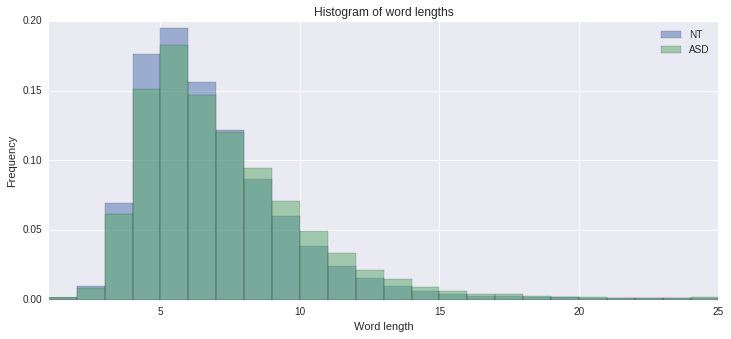

In [150]:
df['len1'] = df['word1'].apply(lambda x:len(x))
df['len2'] = df['word2'].apply(lambda x:len(x))

#word length statistics
print("Mean, minimum, maximum and more.\n" + str(df['len2'].describe()))

## plot word length histogram
nt = df[df['nt']].len1
asd = df[df['nt']==False].len1

w1 = np.ones_like(nt)/len(nt)
w2 = np.ones_like(asd)/len(asd)

bins = np.arange(1,26)

plt.figure(figsize=(12, 5))
plt.hist(nt, bins=bins, alpha=0.5, label="NT", weights=w1)
plt.hist(asd, bins=bins,alpha=0.5, label="ASD", weights=w2)
plt.title('Histogram of word lengths')
plt.xlabel('Word length')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
axes = plt.gca()
axes.set_xlim([1,25])
plt.show()

A post contains on average 7 characters. Most words are between 3 and 15 characters long. The longest word is 200 characters long. NT'ers shorter words, ..

## User activity
Another h. important aspect is user activity..


Total number of users: 6256
11053


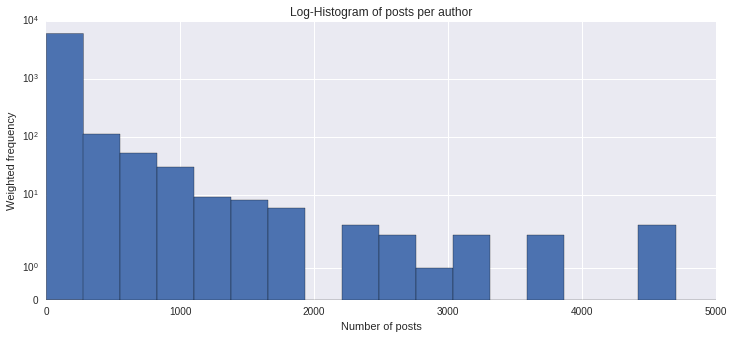

In [160]:
#
print("Total number of users: " + str(len(df.groupby(['author']))))
print(df['author'].value_counts().max())


#Plot
plt.figure(figsize=(12, 5))
plt.hist(df['author'].value_counts(), bins=40)
plt.yscale('symlog')
plt.title('Log-Histogram of posts per author')
plt.xlabel('Number of posts')
plt.ylabel('Weighted frequency')
axes = plt.gca()
axes.set_xlim([1,5000])
plt.show()

This means that on average, each user has posted a word 53 times. However, on online forums there are always people who post only once and people who are almost obsessed by forum games.

## Frequent words
Indeed we have approximately ~0.3M word-pairs. Considering that each word appears twice in the dataset, we also have ~0.3M words contributed by different users at different forums. Due to filtering of pairs containing NaN (empty) values, this is not exactly true, but we simply ignore that for now. Given this enormous bag of words, what would be the most frequently occurring words? Would it be random words like 'fork' or would it represent the most important aspects of life?

In [ ]:
# convert all words to lowercase, otherwise 'Fork' and 'fork' will be counted seperately
df['word1'] = df['word1'].map(str).apply(lambda x: x.lower())
df['word2'] = df['word2'].map(str).apply(lambda x: x.lower())
print(df['word2'].value_counts().head(7))

In [ ]:
plt.figure(figsize=(12, 5))
plt.hist(df['word2'].value_counts(), bins=40)
plt.yscale('log')
plt.title('Log-Histogram of duplicate words.')
plt.xlabel('Number of duplicates')
plt.ylabel('Frequency')
plt.show()

### No forks and spoons
It appears that the most frequent words occuring in association games, are not random at all. Some of the words even are the most important aspects of life, water and food for example...   

(Maybe move to another notebook?)



In [ ]:
#print(nt['word2'].value_counts().head())
#print(asd['word2'].value_counts().head())

## Levenshtein Distance


In [151]:
import Levenshtein

def levenshtein(r):
#	return 1
	return Levenshtein.distance(r.word1, r.word2)

df['edit'] = df.apply(levenshtein, axis=1)
#save interm!

print("Mean edit distance: "+ str(df['edit'].mean()))





Mean edit distance: 6.90909907428


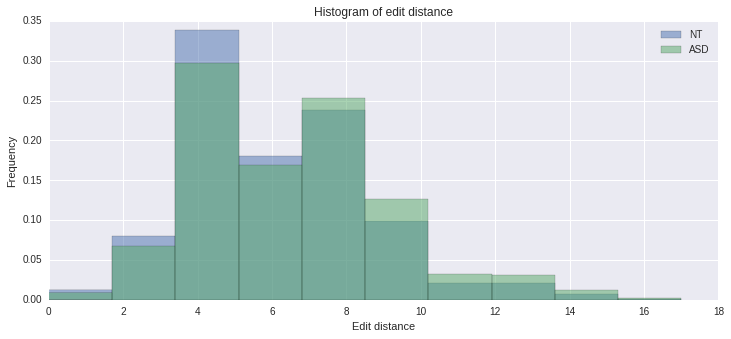

In [154]:
#delete outliers in terms of word length
df = df[(2 < df['len1']) & (df['len1'] < 18) & (2 < df['len2']) & (df['len2'] < 18)]

nt = df[(df['nt'] == True)]
asd = df[(df['nt'] == False)]

weights_nt = np.ones_like(nt['edit'])/len(nt['edit'])
weights_asd = np.ones_like(asd['edit'])/len(asd['edit'])

#nt['edit'].plot.hist(by='edit', bins=15, alpha=0.5, label='NT', weights=weights_nt)
#asd['edit'].plot.hist(by='edit', bins=15, alpha=0.5, label='ASD', weights=weights_asd)

plt.figure(figsize=(12, 5))
plt.hist(nt['edit'], bins=10, alpha=0.5, label="NT", weights=weights_nt)
plt.hist(asd['edit'], bins=10, alpha=0.5, label="ASD", weights=weights_asd)
plt.title('Histogram of edit distance')
plt.xlabel('Edit distance')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.show()